In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
print(os.getcwd())

c:\Users\code\DSL\RegularSession\DimensionalityReduction\training


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [3]:
#데이터 불러오기
fashion=pd.read_csv('./fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [7]:
X = fashion.drop(['label'],axis=1)
y = fashion['label']

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


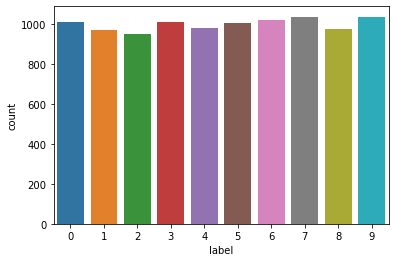

In [28]:
# train dataset으로 10000개 사용하기
X_train = X.loc[:9999,:]
y_train = y.loc[:9999]
sns.countplot(y_train)
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


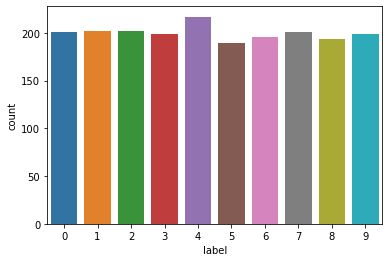

In [23]:
# test dataset으로 2000개 사용하기
X_test = X.loc[40000:41999,:]
y_test = y[40000:42000]
sns.countplot(y_test)
plt.show()
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [30]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 784) (10000,) (2000, 784) (2000,)


- 어떻게 생긴 데이터셋인지 확인해보기

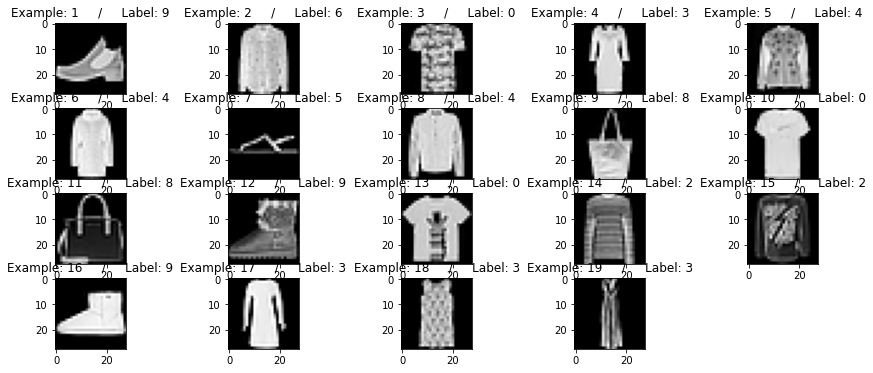

In [65]:
plt.figure(figsize=(15,6))
for i in range(1,20):
  plt.subplot(4,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [31]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784) #784차원의 잠재변수
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(10000, 784)

In [32]:
# 처음 잠재변수는 29%정도 설명...
pca.explained_variance_ratio_[:10]

array([0.2912518 , 0.17484926, 0.06085366, 0.05086107, 0.03783416,
       0.03483235, 0.02289647, 0.01974233, 0.01335667, 0.01306534])

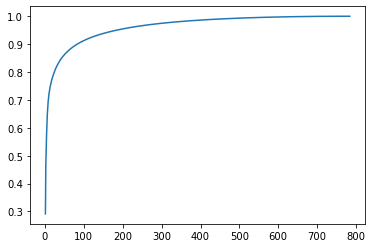

In [33]:
# 누적 분산량 보여주기 -> 총 설명가능한 정도를 파악가능
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [43]:
cumulative=np.array(cumulative)
np.where(cumulative>0.8)[0][0] #23개 쓰면 분산의 80%이상을 설명

23

23개의 주성분을 사용하면 분산의 80%를 설명할 수 있어서 잠재변수를 23개로 설정하려 한다.

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [44]:
#pca를 통한 특징 추출 과정에서는 y라벨을 사용하지X(unsupervised)
#성능 확인 과정에서 y라벨이 사용됨
pca=PCA(n_components=23)
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (10000, 784)
After PCA: (10000, 23)


### 1. Logistic regression

In [45]:
#차원축소 이전(origianl 공간 784차원)
start=time.time()
logistic_original=LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.9766
test accuracy: 0.792
52.7416sec


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
#차원축소 이후(23차원)
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.818
test accuracy: 0.8075
14.8357sec


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- PCA 이전의 경우 52초가 소요되엇지만 PCA 이후 15초로 3배보다 더 빨라짐
- train accuracy가 크게 감소한 것에 비해 test accuracy는 약간 증가하여 이전에는 과대적합이 심했음을 볼 수 있어, 더 robust한 모델을 만들수 있게 됨.
- 더 빠른 학습속도에 성능도 더 좋아져 모델 성능 향상

### 2. Random Forest

In [47]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8515
26.9900sec


In [48]:
#차원축소 이후(23차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.832
8.2905sec


- 차원축소 이후 학습속도가 크게 감소함(아무래도 감소된 차원 수가 크고, 데이터 수가 많은 편이기에 크게 체감되는 듯)
- 성능은 PCA이전이 약간 더 좋긴 함.
- Random forest는 decision tree를 병렬적으로 여러개 사용해서 학습속도가 빠른 편임에도 불구하고 속도 크게 감소함
- 데이터 수가 늘어나거나 빨리 학습을 완료해야 하는 경우에는 여전히 차원축소가 유용할 것

### 3. XGBoost

In [51]:
#차원축소 이전
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8765
373.3044sec


In [52]:
#차원축소 이후
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.836
47.8660sec


- 차원축소 이후 학습속도 감소가 크게 감소함.(순차적 학습이기 때문에 속도 크게 감소)
- 성능은 약간 감소함.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

## PCA
- 분산 크게하는 잠재변수 찾기

In [62]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train[:5000]) 
print(f'{time.time()-start:.4f}sec')

1.8372sec


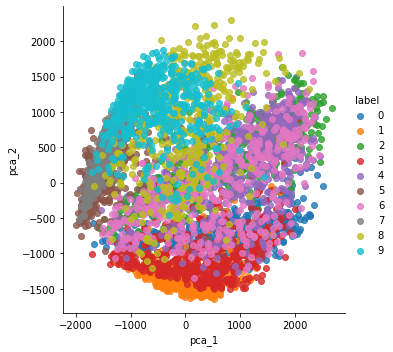

In [63]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train[:5000]), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

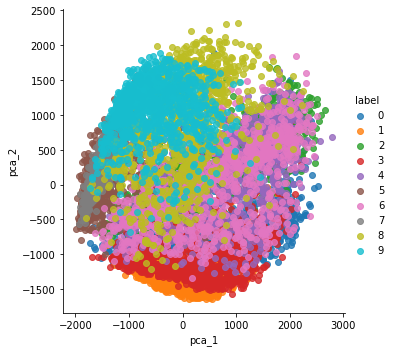

In [54]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

## ISOMAP
- 지오데식 거리를 최대한 보존하는 저차원의 공간을 찾자

In [56]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)    # 이웃하는 애들만 엣지 연결할 때 5개로 연결한다는 것     
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

251.4865sec


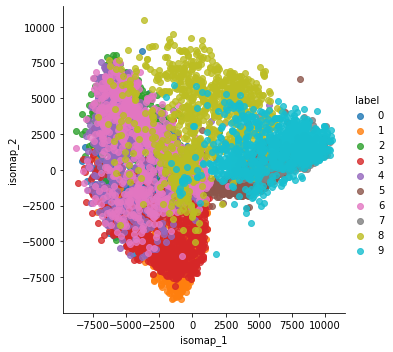

In [57]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

In [58]:
start=time.time()
isomap=Isomap(n_neighbors=10,n_components=2,n_jobs=4)    # 이웃하는 애들만 엣지 연결할 때 10개로 연결한다는 것     
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

286.3283sec


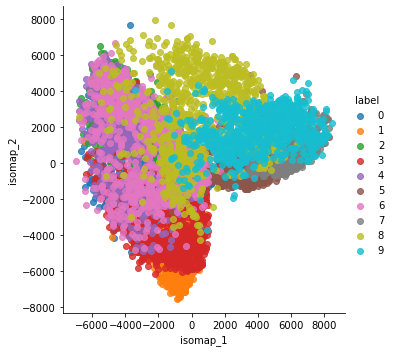

In [59]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

## t-SNE
- 주변 이웃들과의 확률적 관계를 그대로 유지해주는 저차원의 공간을 찾자

In [60]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=42) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


230.0299sec


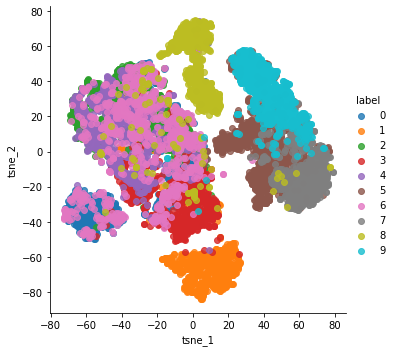

In [61]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

tsne가 가장 시각화가 잘 되고 있다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

- tsne가 그나마 잘 분류가 되고 있어, 이를 통해서 분류가 잘되는 라벨과 그렇지 않은 라벨을 설명해보려고 한다.
- 먼저 분류가 잘 된 라벨은 trouser과 bag으로 다른 라벨들과는 별개의 형태를 가지고 있기에 그런것 같다.
- 나머지 라벨을 보면 크게 신발로 볼수 있는 sandal, sneaker, ankle boot가 뭉쳐져 있고, 팔이 나올수 있는 부분이 존재하는 상의&아우터&원피스 종류들이 뭉쳐져 있는 것을 확인할 수 있다.
- 상의에서는 그나마 t-shirt가 다른 의상들에 비해 팔이 짧기 때문에 별개로 분류되어 있다.
- 가장 분류가 안되는 것은 셔츠와 코트이다.

수고하셨습니다~